# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

# Nasdaq Market

In [1]:
# Load libraries
import os
import pandas as pd
import numpy as np
import time 
import glob
import pickle
from datetime import datetime

In [2]:
path = '../DL4AI-200011-project/data/data-nasdaq/'

In [3]:
nasdaq_csv = glob.glob(os.path.join(path+'csv/', "*.csv"))
print('NASDAQ:',len(nasdaq_csv))

NASDAQ: 1564


In [4]:
# Get some info about the data
pd.read_csv(nasdaq_csv[0]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8437 entries, 0 to 8436
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            8437 non-null   object 
 1   Low             8437 non-null   float64
 2   Open            8437 non-null   float64
 3   Volume          8437 non-null   int64  
 4   High            8437 non-null   float64
 5   Close           8437 non-null   float64
 6   Adjusted Close  8437 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 461.5+ KB


## Choose Companies

### Choose companies based on Nasdaq-100

In [5]:
# Get companies in NASDAQ-100
nasdaq_100 = pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')[4]
nasdaq_100[['Ticker', 'GICS Sector']].head()

,Ticker,GICS Sector
0,ATVI,Communication Services
1,ADBE,Information Technology
2,ADP,Information Technology
3,ABNB,Consumer Discretionary
4,ALGN,Health Care


To have a good prediction, need to get historical data at least 3-5 years -> choose 2017



In [6]:
# get nearest day of dataset
from datetime import datetime
symbol = [] #get list of choosen companies
for company in os.listdir(path+'csv/'):
    name = company.split('.')[0]
    if name in nasdaq_100['Ticker'].values and name != 'LRCX':
        data = pd.read_csv(path+'csv/'+company)
        date = data['Date'].values[0]
        #filter data by established date
        if int(date.split('-')[-1]) <= 2017:
            symbol.append(name)
#pd.DataFrame(symbol).to_csv(path+'stock_symbols.csv', index=False, header = None)
print('Number of choosen companies:', len(symbol))


Number of choosen companies: 65


### Group companies by sector

In [7]:
# group by sector
selected_com = nasdaq_100[nasdaq_100['Ticker'].isin(symbol)]
selected_com = selected_com[['Ticker', 'GICS Sector']].reset_index(drop=True)
selected_com['GICS Sector'].replace(' ','_', regex=True, inplace=True)
# adj list of company and sector
adj_list = {}
for i in range(len(selected_com)):
    if adj_list.get(selected_com['GICS Sector'][i]) is None:
        adj_list[selected_com['GICS Sector'][i]] = [selected_com['Ticker'][i]]
    else:
        adj_list[selected_com['GICS Sector'][i]].append(selected_com['Ticker'][i])

#save group company by sector
with open(path+'symbols.pkl', 'wb') as fp:
    pickle.dump(adj_list, fp)

## Filter company by establish times and sector

In [8]:
# define some parameters
roll_window = 30 #rolling window size for simple moving average
window_size = 30 #history window size, based on which we predict next T days
delta_T =  10 # predict next T days

X_label = []
y_label = []
for i in range(window_size):
    X_label.append('CloseT'+str(-i-1))
for i in range(delta_T):
    y_label.append('CloseT+'+str(i+1))

X_label = X_label + ['Close']

with open(path+'symbols.pkl', 'rb') as fp:
    symbols = pickle.load(fp)

In [9]:
#save adj list of company and sector
if not os.path.exists(path+'filtered_data/'):
    os.makedirs(path+'filtered_data/')
for sector in symbols:
    if not os.path.exists(path+'filtered_data/'+sector+'/'):
        os.makedirs(path+'filtered_data/'+sector+'/')
    for company in adj_list[sector]:
        data = pd.read_csv(path+'csv/'+company+'.csv')
        
        #add label for each company
        for i in range(window_size):
            data['CloseT'+str(-i-1)] = (data['Close'].shift(i+1) - data['Close'])/data['Close']
        for i in range(delta_T):
            data['CloseT+'+str(i+1)] = (data['Close'].shift(-i-1) - data['Close'])/data['Close']
        data = data.dropna().reset_index(drop = True)

        # I see that, if I normalize by min max or mean std, the result is not good
        # Because the the stock price in the future can be much higher than the current price,
        # so our model will not be able to predict it well
        # So I decide to normalize by the current price

        
        #normalize data for each sample (row)
        # data['mean'] = data[X_label].mean(axis=1)
        # data['std'] = data[X_label].std(axis=1)
        # data[X_label] = (data[X_label] - data['mean'].values.reshape(-1,1))/data['std'].values.reshape(-1,1)
        # data[y_label] = (data[y_label] - data['mean'].values.reshape(-1,1))/data['std'].values.reshape(-1,1)
        # data = data.drop(['mean', 'std'], axis=1)
        
        data.to_csv(path+'filtered_data/'+sector+'/'+company+'.csv', index=False)

In [10]:
pd.read_csv(path+'filtered_data/Consumer_Discretionary/'+symbols['Consumer_Discretionary'][0]+'.csv').head(n=3)

,Date,Low,Open,Volume,High,Close,Adjusted Close,CloseT-1,CloseT-2,CloseT-3,...,CloseT+1,CloseT+2,CloseT+3,CloseT+4,CloseT+5,CloseT+6,CloseT+7,CloseT+8,CloseT+9,CloseT+10
0,27-06-1997,0.073958,0.075781,23760000,0.075781,0.074479,0.074479,0.013991,0.013991,0.013991,...,0.034963,0.017481,0.066435,0.283221,0.342660,0.545456,0.559446,0.720284,0.538461,0.433572
1,30-06-1997,0.073958,0.075521,54936000,0.079948,0.077083,0.077083,-0.033782,-0.020264,-0.020264,...,-0.016891,0.030409,0.239871,0.297303,0.493248,0.506765,0.662169,0.486489,0.385143,0.581088
2,01-07-1997,0.075521,0.077083,25848000,0.077083,0.075781,0.075781,0.017181,-0.017181,-0.003431,...,0.048112,0.261174,0.319592,0.518903,0.532653,0.690727,0.512028,0.408942,0.608253,0.539528


## Build model

In [11]:
# Import libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras import initializers, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-05-31 10:20:36.701414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(window_size, 1))
        self.lstm1 = LSTM(window_size, return_sequences=True)
        self.lstm2 = LSTM(window_size)
        self.dropout = Dropout(0.5)
        self.dense1 = Dense(window_size, activation='tanh')
        self.dense2 = Dense(delta_T, activation='tanh')
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.lstm1(x)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [13]:
#load data from filtered data
X_data = {}
y_data = {}
sector = glob.glob(os.path.join(path+'filtered_data/', "*"))
for sec in sector:
    companies = glob.glob(os.path.join(sec+'/', "*.csv"))
    if sec.split('/')[-1] not in X_data:
        X_data[sec.split('/')[-1]] = {}
        y_data[sec.split('/')[-1]] = {}
    for company in companies:
        name = company.split('/')[-1].split('.')[0]
        X_data[sec.split('/')[-1]][name] = pd.read_csv(company)[X_label]
        y_data[sec.split('/')[-1]][name] = pd.read_csv(company)[y_label]

print(X_data['Consumer_Discretionary']['AMZN'].columns[:5])
print(y_data['Consumer_Discretionary']['AMZN'].columns[:5])

Index(['CloseT-1', 'CloseT-2', 'CloseT-3', 'CloseT-4', 'CloseT-5'], dtype='object')
Index(['CloseT+1', 'CloseT+2', 'CloseT+3', 'CloseT+4', 'CloseT+5'], dtype='object')


Because of positive correlation between each companies in same sector, so we build each prediction model for each sector

Sector model can learn from all companies in sector's companies

In [14]:
if not os.path.exists(path+'model/'):
    os.makedirs(path+'model/')
for sec in symbols:
    # get sector, each model is trained for each sector
    print('Training sector', sec.split('/')[-1])
    model = Model()

    model.compile(optimizer= Adam(learning_rate=0.001, decay = 0.01), loss='mse')
    callback = EarlyStopping(monitor='val_loss', patience=10)
    #checkout
    checkout_path = path+'model/'+sec.split('/')[-1]+'/model.ckpt'
    checkout = ModelCheckpoint(checkout_path, save_best_only=True, save_weights_only=True,verbose=0)
    X_train_sec, y_train_sec, X_val_sec, y_val_sec, X_test_sec, y_test_sec = [], [], [], [], [], []
    print('Get company: ') 
    for company in X_data[sec.split('/')[-1]]:
        print(company, end=' ')
        val_size = 0.1
        test_size = 300 #days
        X = np.array(X_data[sec.split('/')[-1]][company].values)
        y = np.array(y_data[sec.split('/')[-1]][company].values)
        X_train = X[:-test_size]
        y_train = y[:-test_size]
        X_test = X[-test_size:]
        y_test = y[-test_size:]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=False)

        #reshape data
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

        #concat to X_train_sec, y_train_sec, X_val_sec, y_val_sec, X_test_sec, y_test_sec
        X_train_sec = np.concatenate((X_train_sec, X_train), axis=0) if len(X_train_sec) != 0 else X_train
        y_train_sec = np.concatenate((y_train_sec, y_train), axis=0) if len(y_train_sec) != 0 else y_train
        X_val_sec = np.concatenate((X_val_sec, X_val), axis=0) if len(X_val_sec) != 0 else X_val
        y_val_sec = np.concatenate((y_val_sec, y_val), axis=0) if len(y_val_sec) != 0 else y_val
        X_test_sec = np.concatenate((X_test_sec, X_test), axis=0) if len(X_test_sec) != 0 else X_test
        y_test_sec = np.concatenate((y_test_sec, y_test), axis=0) if len(y_test_sec) != 0 else y_test
        
    #shuffle data
    X_train_sec, y_train_sec = shuffle(X_train_sec, y_train_sec)
    
    #train model
    model.fit(X_train_sec, y_train_sec, epochs=100, batch_size=2048, validation_data=(X_val_sec, y_val_sec), callbacks=[callback, checkout], verbose=0)
    
    #evaluate model
    model.evaluate(X_test_sec, y_test_sec)

    print('Finish training sector', sec.split('/')[-1])
    print('--------------------------------------')

Training sector Communication_Services


2023-05-31 10:20:46.931804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:20:47.038269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:20:47.038493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:20:47.039637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

Get company: 
ATVI CHTR CMCSA EA SIRI NFLX 

2023-05-31 10:20:50.528886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


57/57 [==============================] - 0s 2ms/step - loss: 0.0033
Finish training sector Communication_Services
--------------------------------------
Training sector Information_Technology
Get company: 
244/244 [==============================] - 0s 2ms/step - loss: 0.0040NT NXPI MRVL MCHP ENPH CSCO NVDA INTC MU ADI CT
Finish training sector Information_Technology
--------------------------------------
Training sector Health_Care
Get company: 
104/104 [==============================] - 0s 2ms/step - loss: 0.0038
Finish training sector Health_Care
--------------------------------------
Training sector Consumer_Discretionary
Get company: 
94/94 [==============================] - 0s 2ms/step - loss: 0.0047
Finish training sector Consumer_Discretionary
--------------------------------------
Training sector Industrials
Get company: 
66/66 [==============================] - 0s 2ms/step - loss: 0.0023
Finish training sector Industrials
--------------------------------------
Training sector 

## Buy and Sell point

Find optimal way to maximum profit

In [15]:
def max_profit(prices, threshold):
    n = len(prices)
    if n < 2:
        return 0, [], []

    selling_date = 0
    buying_date = 0
    total_profit = 0
    buy_times = []
    sell_times = []

    for i in range(1, len(prices)):
        if prices[i] >= prices[i - 1]:
            selling_date += 1
        else:
            profit = prices[selling_date] - prices[buying_date]
            if profit > threshold:
                total_profit += profit
                buy_times.append(buying_date)
                sell_times.append(selling_date)
            selling_date = buying_date = i

    profit = prices[selling_date] - prices[buying_date]
    if profit > threshold:
        total_profit += profit
        buy_times.append(buying_date)
        sell_times.append(selling_date)

    return total_profit, buy_times, sell_times


/tmp/ipykernel_5444/1015125796.py:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  load_data['Date'] = pd.to_datetime(load_data['Date'])


1/1 [==============================] - 1s 713ms/step
real profit: -0.00999832153321023
expected profit: 0.8149566650390625


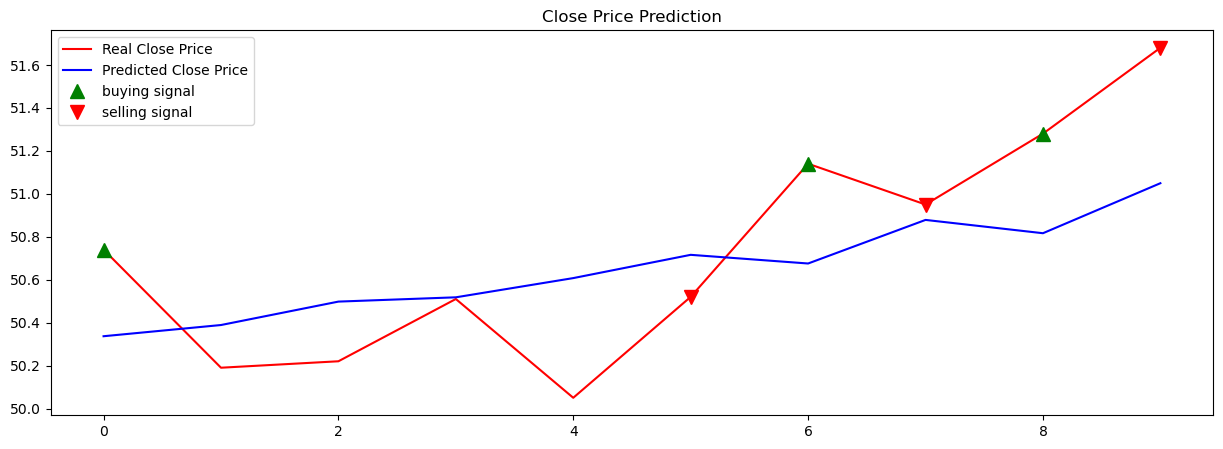

In [16]:
# test our algorithm

import matplotlib.pyplot as plt
#test buy sell
load_model = Model()
load_model.load_weights(path+'model/Communication_Services/model.ckpt')
load_data = pd.read_csv(path+'csv/CMCSA.csv')

date_trade = datetime(2022, 1, 1)
load_data['Date'] = pd.to_datetime(load_data['Date'])
x_data  = load_data[load_data['Date'] <= date_trade][-window_size-1:]
y_data = load_data[load_data['Date'] > date_trade][:delta_T]

today_price = x_data.iloc[-1]['Close']
x_data  = x_data['Close'].values
y_data = y_data['Close'].values
#normalize data
x_data = (x_data - today_price)/today_price

x_data = x_data.reshape(1, x_data.shape[0], 1)
pred_data = load_model.predict(x_data)[0]
pred_data = pred_data*today_price + today_price

fig = plt.figure(figsize = (15,5))
profit, buy, sell = max_profit(pred_data, threshold = 0.04)
real_profit = 0
for i in range(len(buy)):
    real_profit += y_data[sell[i]] - y_data[buy[i]]

print('real profit:', real_profit)    
print('expected profit:', profit)

plt.plot(y_data, color='red', label = 'Real Close Price')
plt.plot(pred_data, color='blue', label = 'Predicted Close Price')
plt.plot(y_data, '^', markersize=10, color='g', label = 'buying signal', markevery = buy)
plt.plot(y_data, 'v', markersize=10, color='r', label = 'selling signal', markevery = sell)
plt.title('Close Price Prediction')
plt.legend()
plt.show()

## Portfolio Management

Trading by our model, and find the top expected profit

In [17]:
path = '../DL4AI-200011-project/data/data-nasdaq/'
window_size = 30 #history window size
delta_T =  10 # predict next T days
threshold = 0.1 # threshold for buying and selling
future_day = []
trade_date = datetime(2021, 8, 21)

# Trade stock by our model
def trading(now, path, threshold, window_size = 30, delta_T = 10):
    date = pd.read_csv(path+'csv/AAPL.csv')
    date['Date'] = pd.to_datetime(date['Date'])
    date = list(date[date['Date'] > now]['Date'].values[:delta_T])
    #just keep day and month
    date = [str(i).split('T')[0][5:] for i in date]
    trade_table = pd.DataFrame(columns = ['Company', 'Sector','Profit']+ date)
    
    with open(path+'symbols.pkl', 'rb') as fp:
        symbols = pickle.load(fp)
    for sec in symbols:
        model = Model()
        model.load_weights(path+'model/'+sec+'/model.ckpt')
        for company in symbols[sec]:
            #get company data
            data = pd.read_csv(path+'csv/'+company+'.csv')
            data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
            x_data  = data[data['Date'] <= now][-window_size-1:]

            today_price = x_data.iloc[-1]['Close']
            x_data  = x_data['Close'].values

            #normalize data
            x_data = (x_data - today_price)/today_price
            x_data = x_data.reshape(1, x_data.shape[0], 1)

            pred = model.predict(x_data)[0]
            pred = pred*today_price + today_price
            
            profit, buy_times, sell_times = max_profit(pred, threshold)
            if profit == 0:
                continue
            pred_table = {}
            pred_table['Company'] = company
            pred_table['Sector'] = sec
            pred_table['Profit'] = profit
            
            for i in range(len(pred)):
                if i in buy_times:
                    pred_table[date[i]] = 'buy'
                elif i in sell_times:
                    pred_table[date[i]] = 'sell'
                else:
                    pred_table[date[i]] = ' '
            trade_table = pd.concat([trade_table, pd.DataFrame(pred_table, index = [0], columns=['Company', 'Sector','Profit']+ date)])
            sort_table = trade_table.sort_values(by=['Profit'], ascending=False)
    return sort_table

trade_table = trading(now = trade_date, path = path, threshold = threshold, window_size = window_size, delta_T = delta_T)
trade_table.to_csv(path+'trade_table.csv', index=False)

/tmp/ipykernel_5444/3650599768.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  date['Date'] = pd.to_datetime(date['Date'])


1/1 [==============================] - 1s 653ms/step


## Display top companies in portfolio

In [18]:
trade_table = pd.read_csv(path+'trade_table.csv')
print('top 10 profitable companies')
trade_table.head(10)

top 10 profitable companies


,Company,Sector,Profit,11-01,12-01,09-02,10-02,11-02,12-02,09-03,10-03,11-03,12-03
0,MELI,Consumer_Discretionary,17.219238,buy,sell,buy,,,,,,,sell
1,CHTR,Communication_Services,12.901123,buy,,,,,sell,buy,sell,buy,sell
2,NFLX,Communication_Services,9.087830,buy,,,,,sell,buy,sell,buy,sell
3,ASML,Information_Technology,8.278687,,buy,,,,,,,,sell
4,REGN,Health_Care,8.158875,buy,,,,,,,,,sell
5,ALGN,Health_Care,7.905334,buy,,,,,,,,,sell
6,IDXX,Health_Care,7.797424,buy,,,,,,,,,sell
7,ADBE,Information_Technology,6.780762,,buy,,,,,,,,sell
8,ORLY,Consumer_Discretionary,6.708557,buy,,,,,,,,,sell
9,INTU,Information_Technology,5.685059,,buy,,,,,,,,sell


In [19]:
print('top 10 loss companies')
trade_table.tail(10)

top 10 loss companies


,Company,Sector,Profit,11-01,12-01,09-02,10-02,11-02,12-02,09-03,10-03,11-03,12-03
54,CPRT,Industrials,0.790367,buy,,sell,buy,,,,,,sell
55,JD,Consumer_Discretionary,0.750465,buy,,,,,,,,,sell
56,MCHP,Information_Technology,0.739479,,buy,,,,,,,,sell
57,FTNT,Information_Technology,0.632370,,buy,,,,,,,,sell
58,MRVL,Information_Technology,0.622299,,buy,,,,,,,,sell
59,CSCO,Information_Technology,0.618259,,buy,,,,,,,,sell
60,INTC,Information_Technology,0.534214,,buy,,,,,,,,sell
61,FAST,Industrials,0.527641,buy,,,sell,buy,,,sell,,
62,MDLZ,Consumer_Staples,0.425922,,,buy,,sell,buy,sell,,,
63,WBA,Consumer_Staples,0.323563,,,buy,,sell,buy,sell,,,


## Build App

In [20]:
!streamlit run ../DL4AI-200011-project/stock_trading_app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.194:8501

2023-05-31 10:23:39.928886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 10:23:41.309806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:23:41.327101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:23:41.327304: I tensorflow